In [1]:
import glob
import os
from typing import Any, Dict, List, Tuple

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [2]:
base_plot_dir = "plots/"
os.makedirs(base_plot_dir, exist_ok=True)

In [3]:
def plot_kappas(result_dfs: Dict[str, pd.DataFrame], fn: str):
    nrows = len(result_dfs) // 2
    if len(result_dfs) % 2 > 0:
        nrows += 1
    ncols = 2
    fig, axes = plt.subplots(nrows, ncols, figsize=(ncols * 20, nrows * 10))

    for i, (name, df) in enumerate(result_dfs.items()):
        ax = axes.flat[i]
        ax.plot(df["epoch"], df["kappa"], label=name)
        ax.set_xlabel("Epoch")
        ax.set_ylabel("Kappa")
        ax.set_title(name)

    plt.tight_layout()
    plt.savefig(fn)
    # plt.close()

def plot_loss(result_dfs: Dict[str, pd.DataFrame], fn: str):
    fig, ax = plt.subplots(1, 1, figsize=(20, 10))

    for i, (name, df) in enumerate(result_dfs.items()):
        ax.plot(df["epoch"], df["total_loss"], label=name)
        ax.set_xlabel("Epoch")
        ax.set_ylabel("Loss")
        ax.set_yscale("log")
    ax.set_title("Loss Progression across Epochs")
    ax.legend(loc="upper right")

    plt.tight_layout()
    plt.savefig(fn)
    # plt.close()

def plot_rar_sampled_points_ts(sampled_points: Dict[str, List[np.ndarray]], fn: str):
    '''
    Sampled points is a numpy array of shape (n_outer_loop, n_samples, n_dim)
    '''
    nrows = len(sampled_points) // 2
    if len(sampled_points) % 2 > 0:
        nrows += 1
    ncols = 2
    fig, axes = plt.subplots(nrows, ncols, figsize=(ncols * 10, nrows * 10))

    for i, (name, points) in enumerate(sampled_points.items()):
        ax = axes.flat[i]
        for i in range(len(points)):
            ax.scatter(points[i][:, 0], points[i][:, 1], label=f"Outer Loop {i+1}")
        ax.set_xlabel("$z_1$")
        ax.set_ylabel("$z_2$")
        ax.legend()
        ax.set_title(f"RARG Sampled Points for {name}")

    plt.tight_layout()
    plt.savefig(fn)

In [4]:
loss_dicts = {}
kappa_dicts = {}
rar_sampled_points = {}
n_trees = 3

name_map = {
    ("single_output", "", "uniform", ""): "NN Single Output, Uniform Sampling",
    ("single_output", "", "log_normal", ""): "NN Single Output, Log Normal Sampling",
    ("single_output", "", "uniform", "_ts"): "NN Single Output, Uniform Sampling, Time Stepping",
    ("single_output", "", "log_normal", "_ts"): "NN Single Output, Log Normal Sampling, Time Stepping",

    ("single_output", "_rar", "uniform", ""): "NN Single Output, Uniform Sampling, RARG",
    ("single_output", "_rar", "log_normal", ""): "NN Single Output, Log Normal Sampling, RARG",
    ("single_output", "_rar", "uniform", "_ts"): "NN Single Output, Uniform Sampling, Time Stepping, RARG",
    ("single_output", "_rar", "log_normal", "_ts"): "NN Single Output, Log Normal Sampling, Time Stepping, RARG",

    ("multioutput", "", "uniform", ""): "NN Multi-Output, Uniform Sampling",
    ("multioutput", "", "log_normal", ""): "NN Multi-Output, Log Normal Sampling",
    ("multioutput", "", "uniform", "_ts"): "NN Multi-Output, Uniform Sampling, Time Stepping",
    ("multioutput", "", "log_normal", "_ts"): "NN Multi-Output, Log Normal Sampling, Time Stepping",

    ("multioutput", "_rar", "uniform", ""): "NN Multi-Output, Uniform Sampling, RARG",
    ("multioutput", "_rar", "log_normal", ""): "NN Multi-Output, Log Normal Sampling, RARG",
    ("multioutput", "_rar", "uniform", "_ts"): "NN Multi-Output, Uniform Sampling, Time Stepping, RARG",
    ("multioutput", "_rar", "log_normal", "_ts"): "NN Multi-Output, Log Normal Sampling, Time Stepping, RARG",
}

for output_type in ["single_output", "multioutput"]:
    for rar_suffix in ["", "_rar"]:
        topfolder_path = f"models_{output_type}{rar_suffix}"
        for sample_types in ["uniform", "log_normal"]:
            for ts_suffix in ["", "_ts"]:
                target_name = name_map[(output_type, rar_suffix, sample_types, ts_suffix)]

                second_folder_path = f"tree{n_trees}{ts_suffix}_{sample_types}"
                folder_path = os.path.join(topfolder_path, second_folder_path)
                loss_df = pd.read_csv(os.path.join(folder_path, "min_loss.csv"))
                kappa_df = pd.read_csv(os.path.join(folder_path, "kappa_val.csv"))
                kappa_cols = [f"kappa_{i+1}" for i in range(n_trees)]
                kappa_df["kappa"] = kappa_df[kappa_cols].mean(axis=1)
                loss_dicts[target_name] = loss_df
                kappa_dicts[target_name] = kappa_df
                if rar_suffix=="_rar" and ts_suffix == "_ts":
                    anchor_point_files = glob.glob(os.path.join(folder_path, "anchor_points_*.npy"))
                    curr_rar_sampled_points = []
                    for anchor_point_file in anchor_point_files:
                        curr_rar_sampled_points.append(np.load(anchor_point_file))
                    rar_sampled_points[target_name] = curr_rar_sampled_points

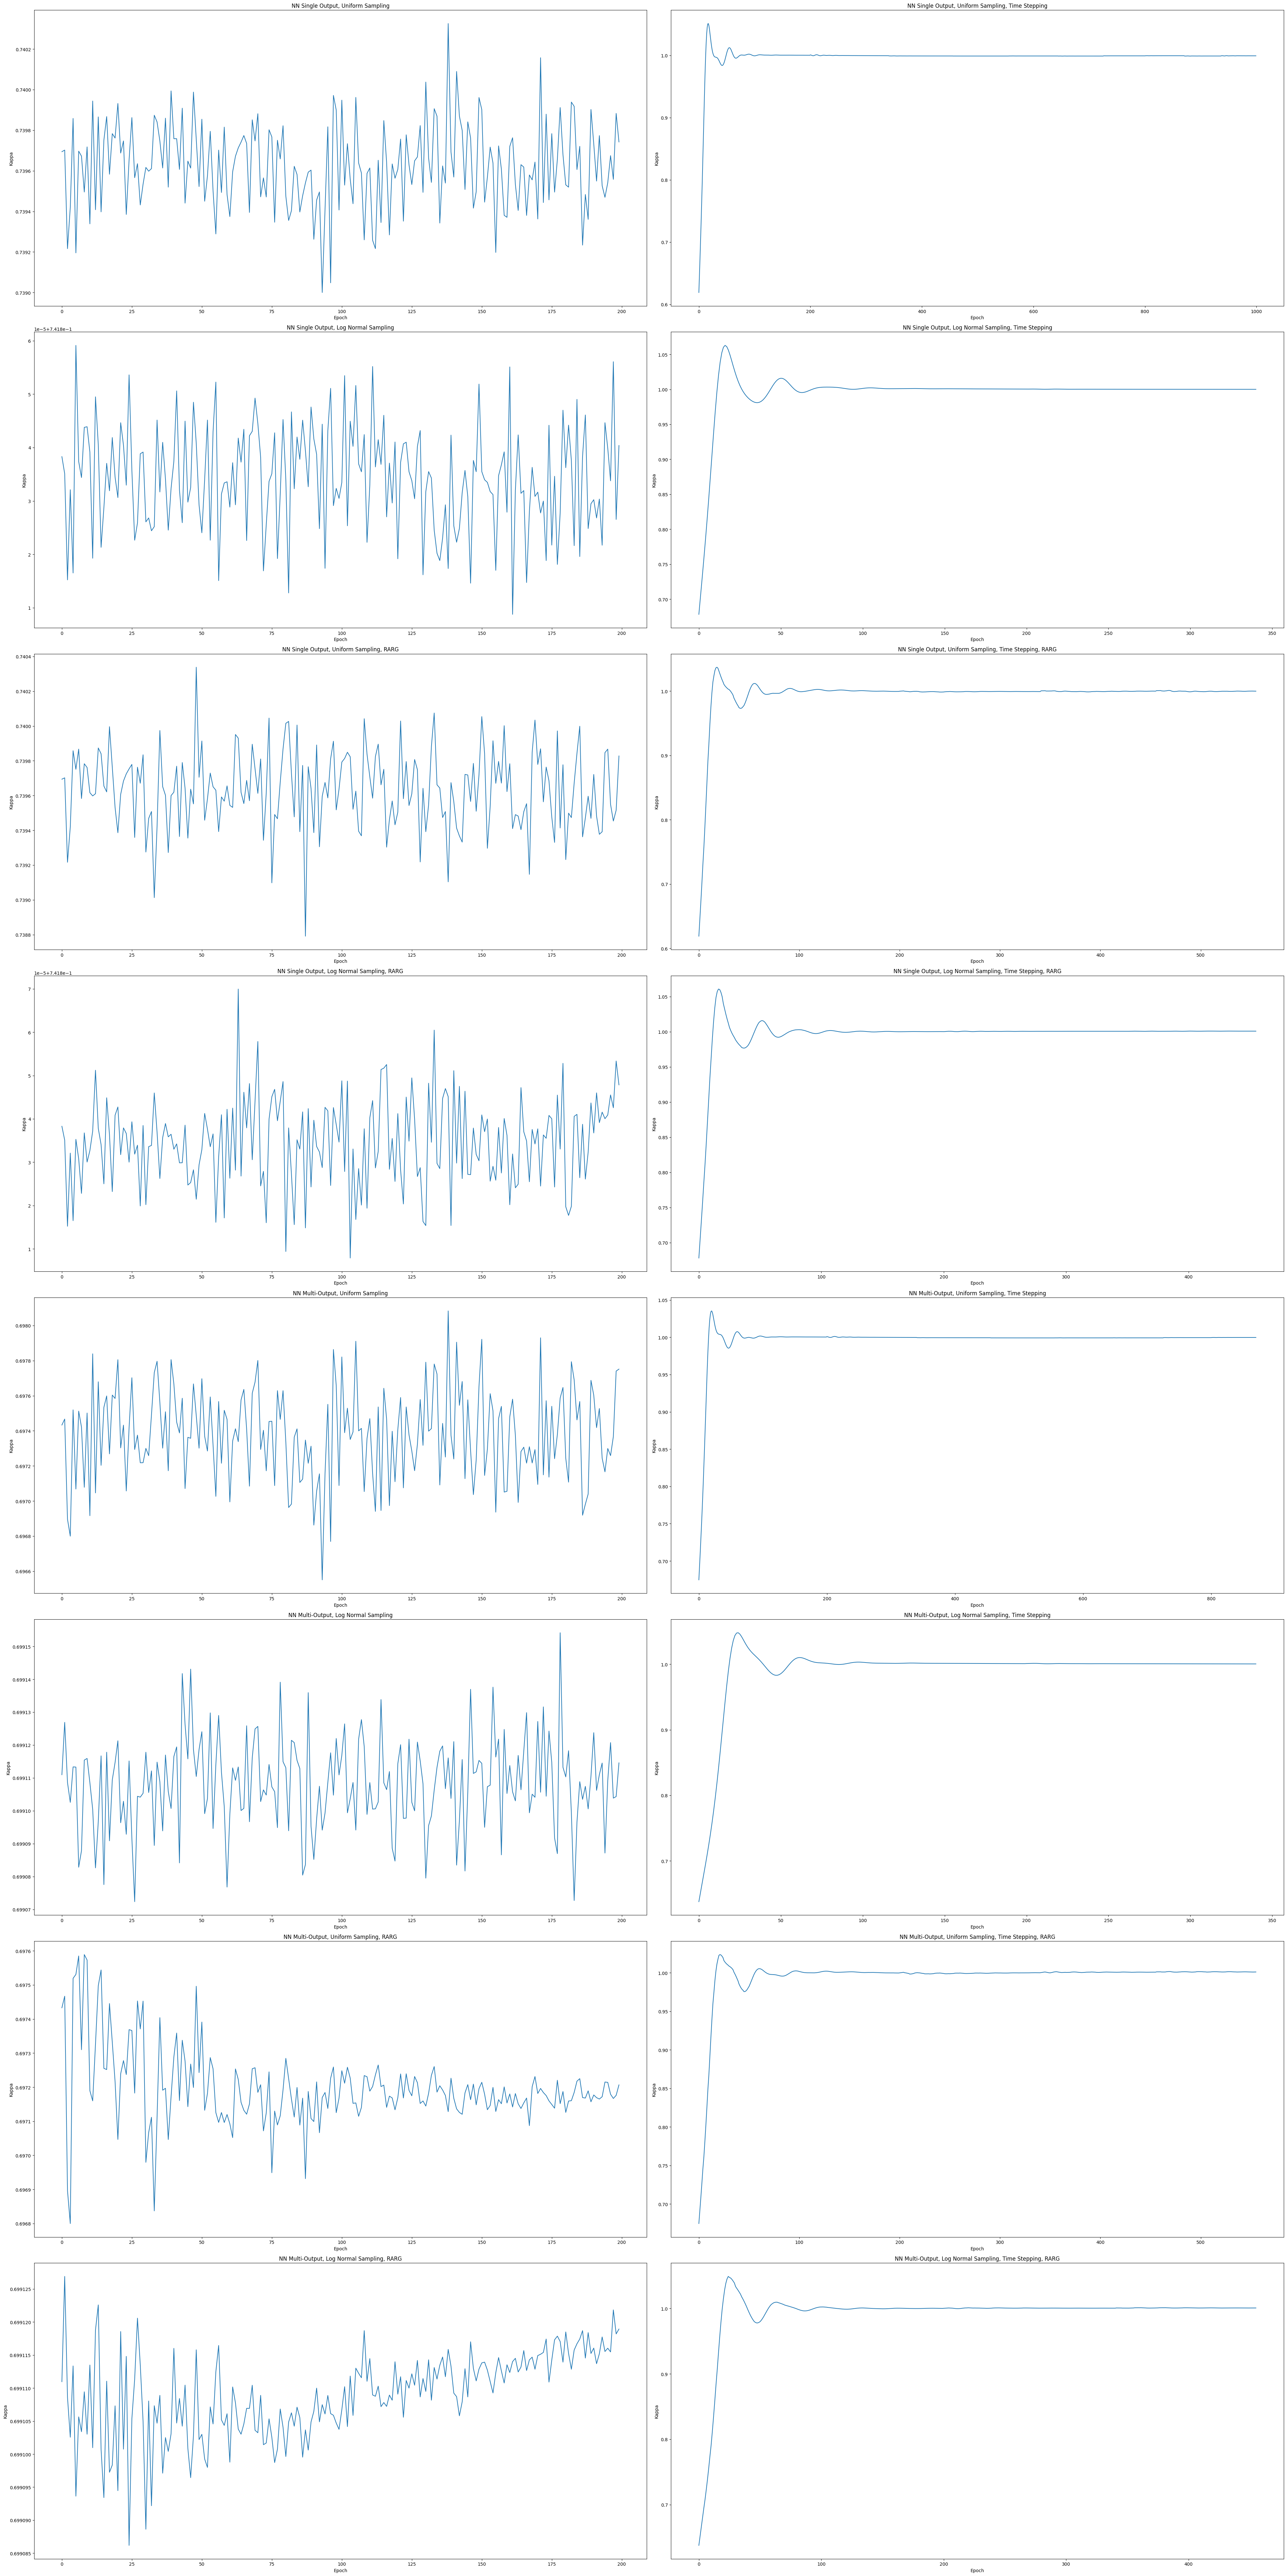

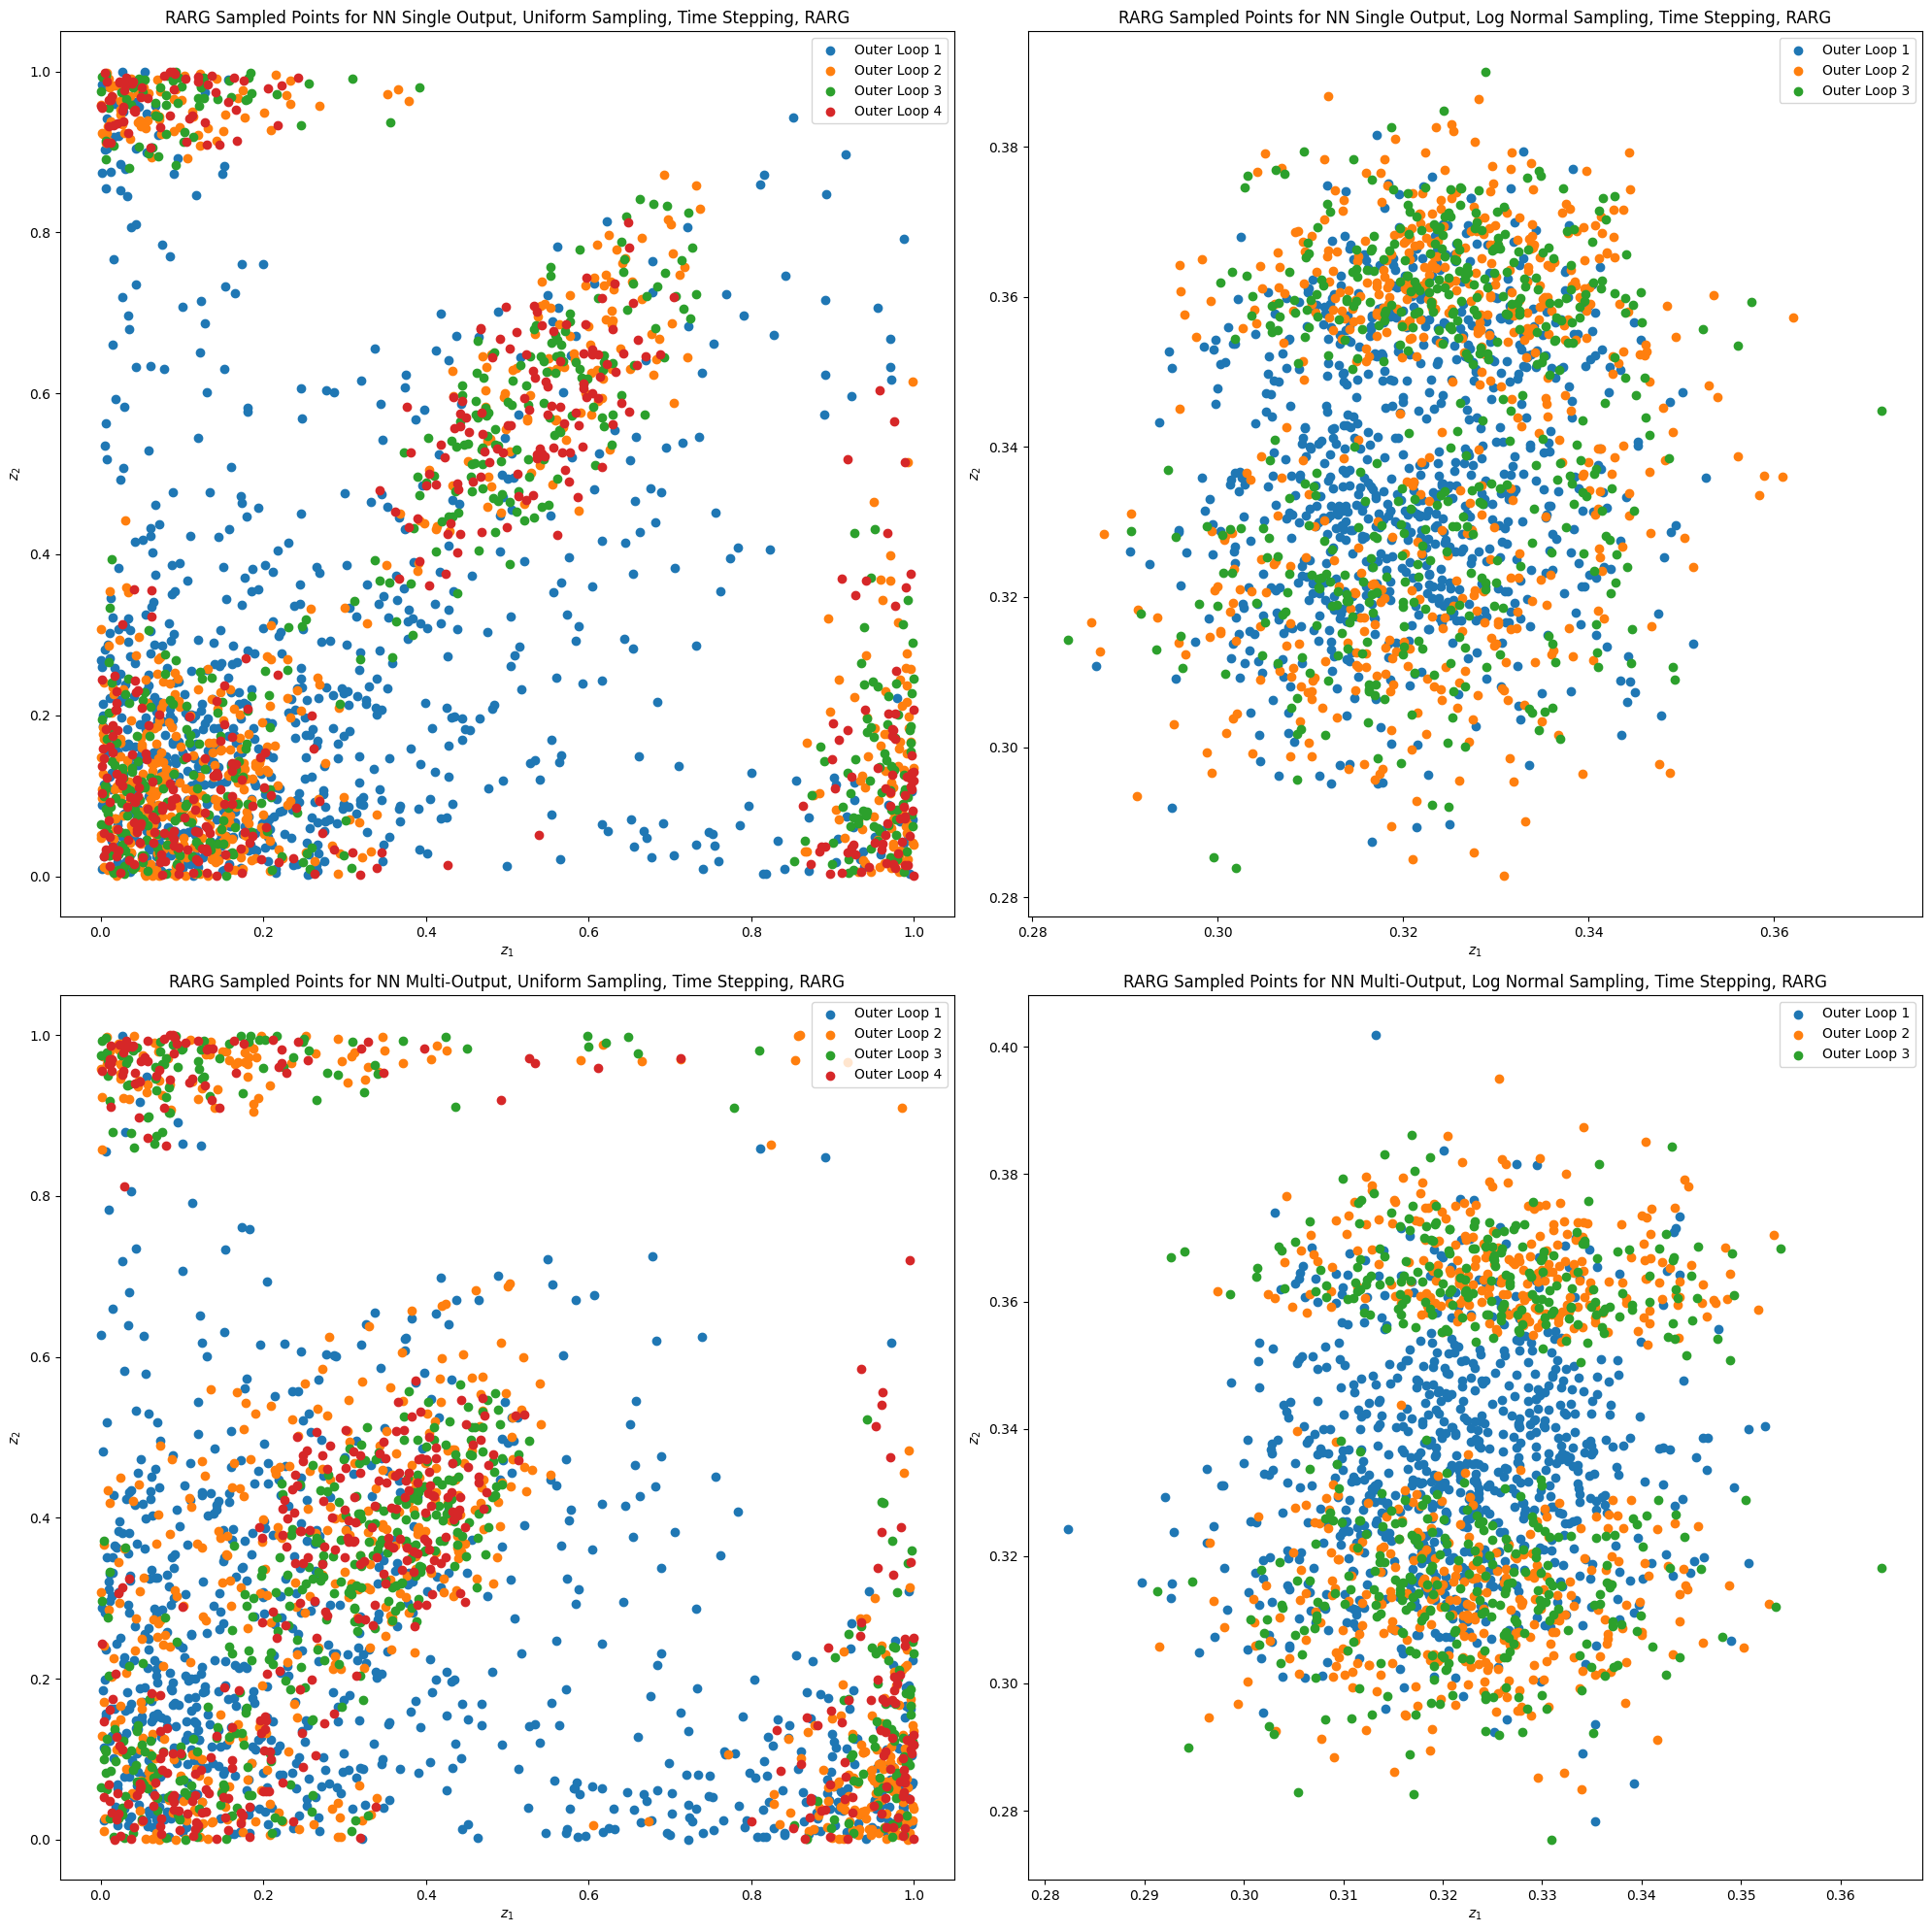

In [5]:
plot_kappas(kappa_dicts, f"{base_plot_dir}/kappa_plots.png")
plot_rar_sampled_points_ts(rar_sampled_points, f"{base_plot_dir}/rar_sampled_points_ts.png")

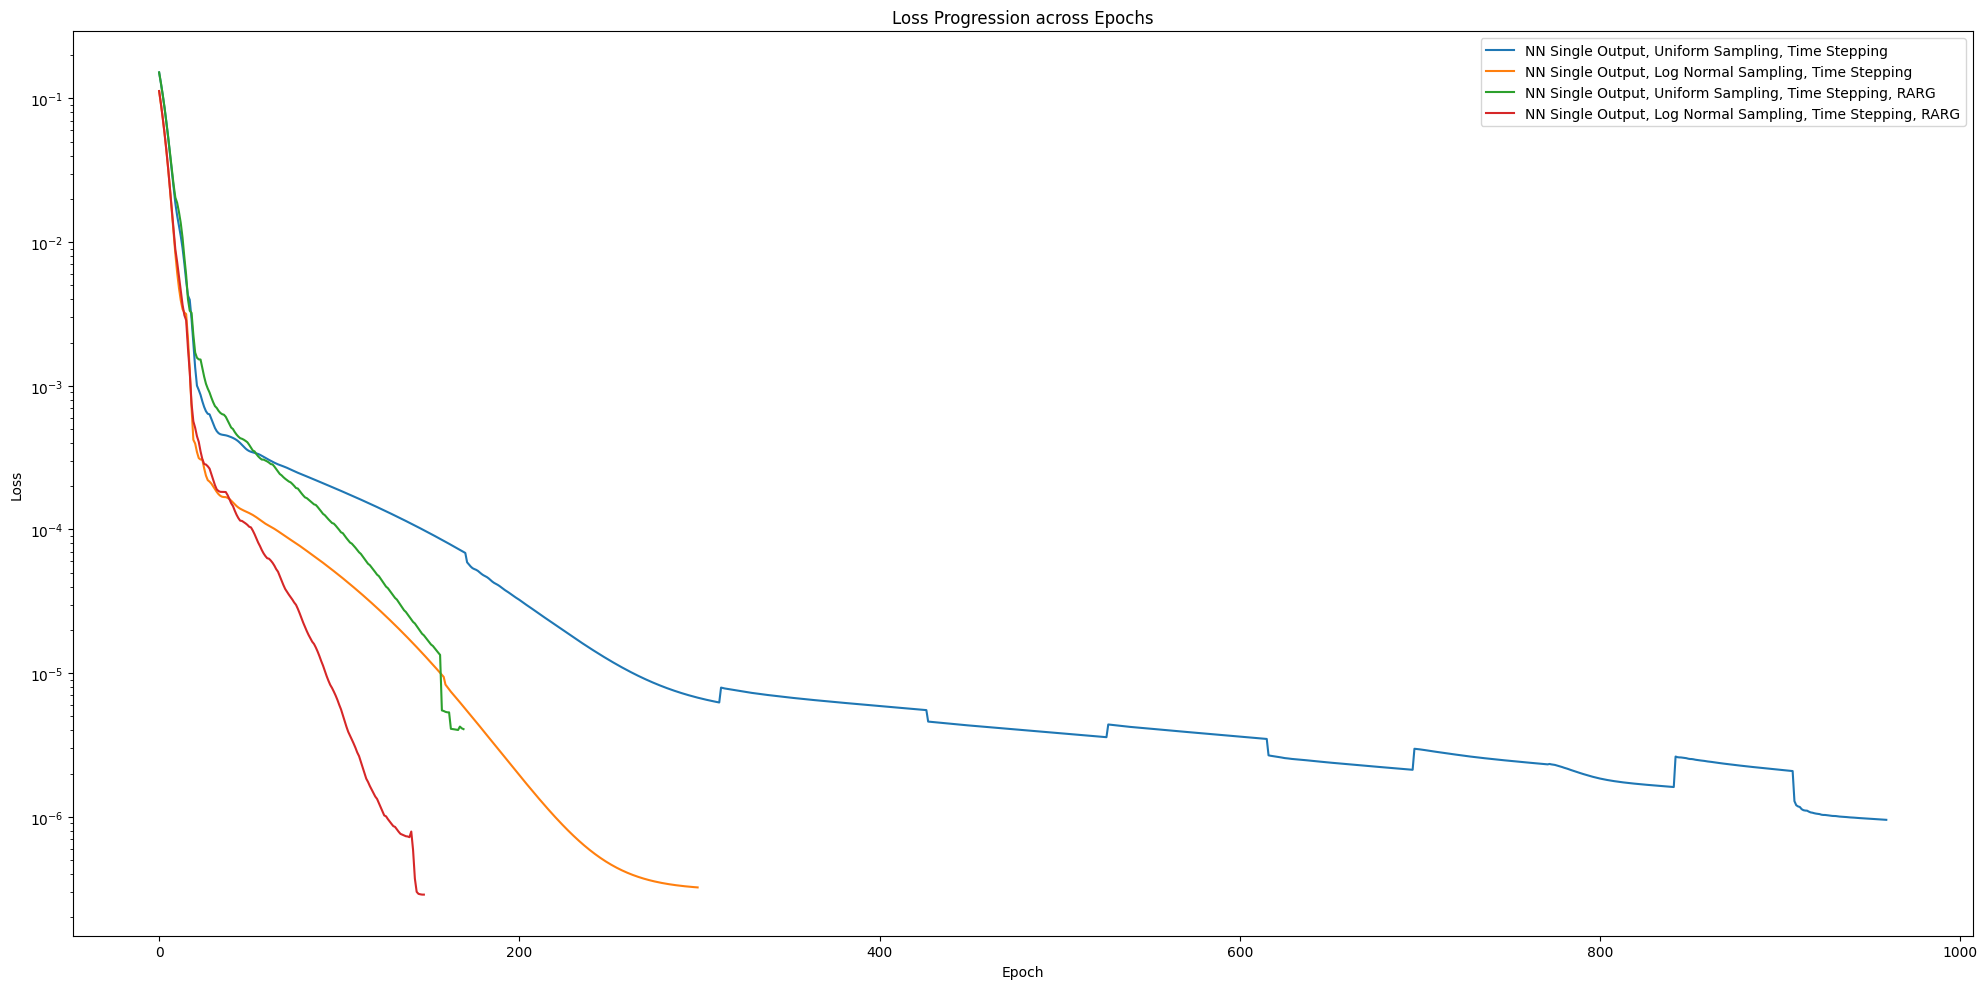

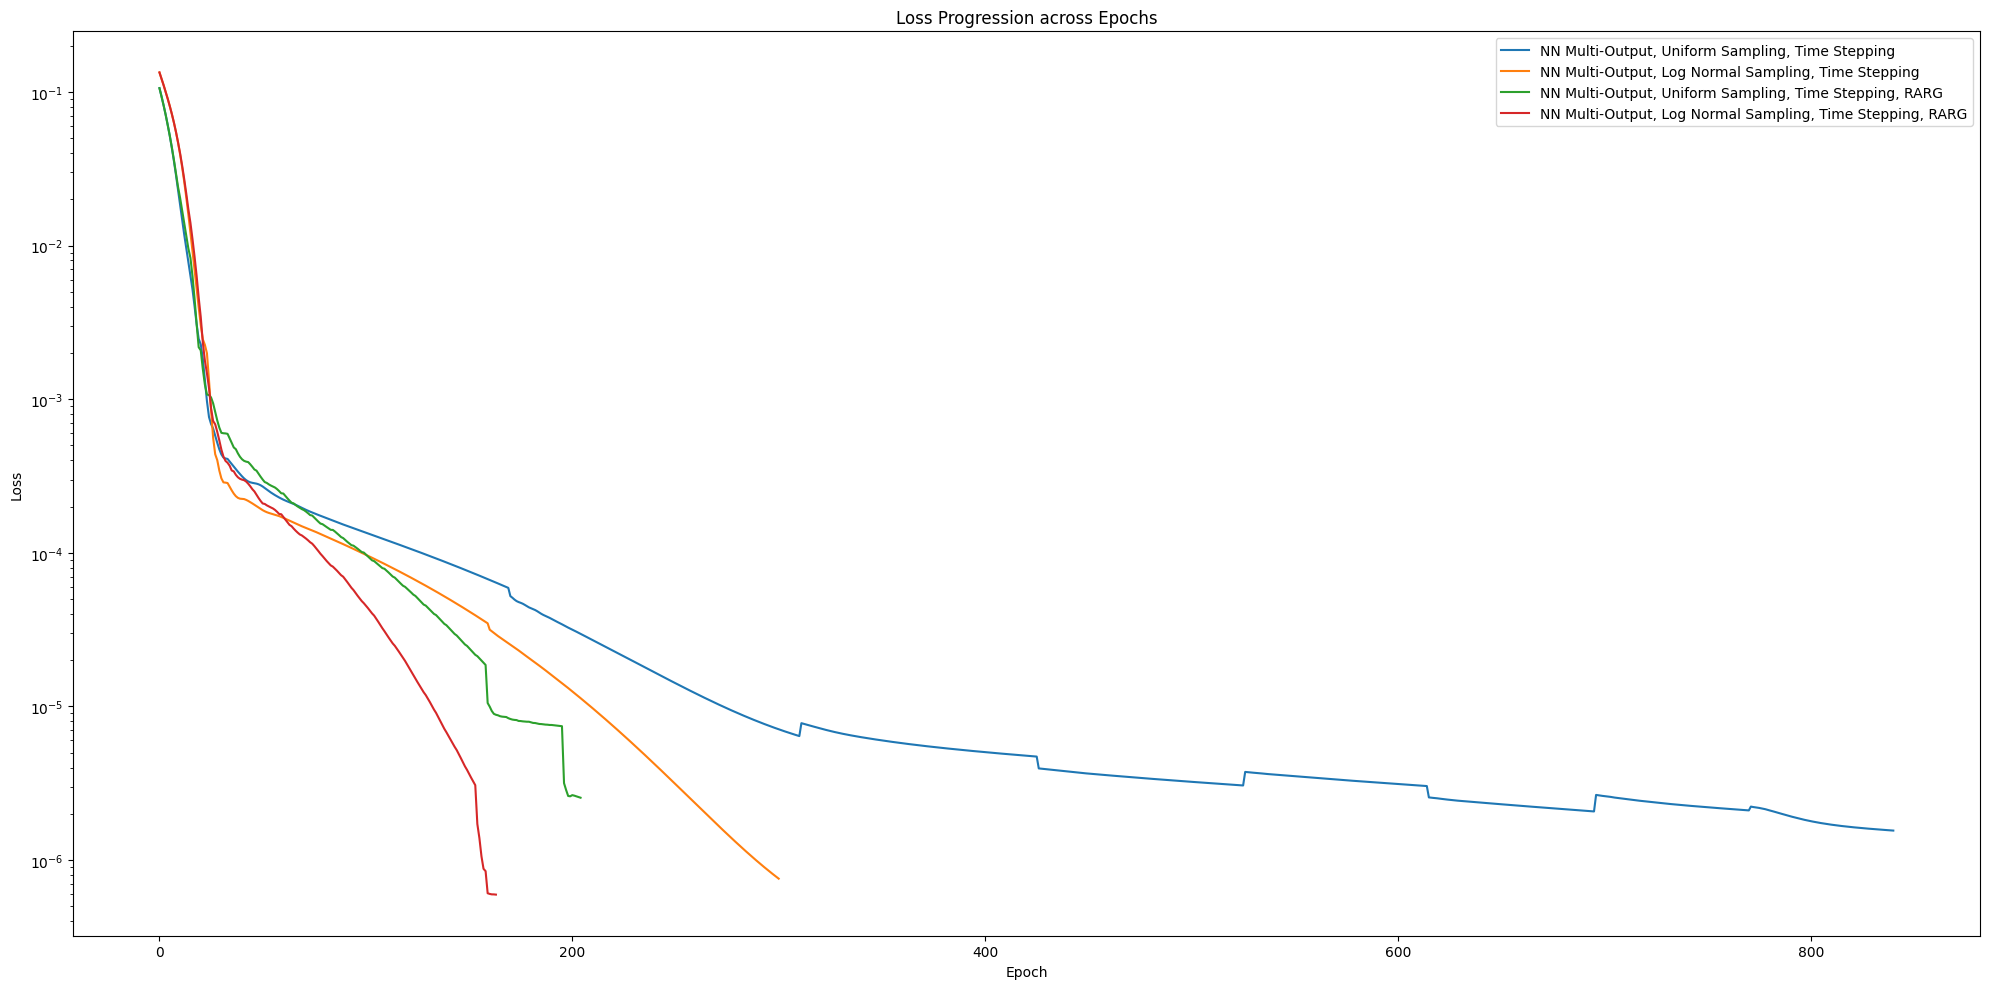

In [6]:
loss_to_plot1_labels = [
    "NN Single Output, Uniform Sampling, Time Stepping",
    "NN Single Output, Log Normal Sampling, Time Stepping",
    "NN Single Output, Uniform Sampling, Time Stepping, RARG",
    "NN Single Output, Log Normal Sampling, Time Stepping, RARG",
]
loss_to_plot2_labels = [
    "NN Multi-Output, Uniform Sampling, Time Stepping",
    "NN Multi-Output, Log Normal Sampling, Time Stepping",
    "NN Multi-Output, Uniform Sampling, Time Stepping, RARG",
    "NN Multi-Output, Log Normal Sampling, Time Stepping, RARG",
]
loss_to_plot1 = {k: loss_dicts[k] for k in loss_to_plot1_labels}
loss_to_plot2 = {k: loss_dicts[k] for k in loss_to_plot2_labels}

plot_loss(loss_to_plot1, f"{base_plot_dir}/single_output_loss_plots.png")
plot_loss(loss_to_plot2, f"{base_plot_dir}/multioutput_loss_plots.png")